# Transformations and Linear Regression


## Learning Objectives

After studying this notebook, attending class, asking questions, and reviewing your notes, you should be able to:
* Develop transformations for some nonlinear models and apply linear regression
* Perform residual analysis for linear regression (as a diagnostic plot)
* Calculate standard errors (i.e., standard deviation) of the residuals
* Assemble the covariance matrix for linear regression using normal equations (i.e., feature matrix $\mathbf{X}$)

In [1]:
# load libraries
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt

## Introduction

Often as engineers, we need to model nonlinear phenomena. In this notebook, we will learn how to extend ideas from linear regression to fit parameters that in nonlinear model equations. We will also learn how to estimate uncertainty in these fitted parameters.

Unfortunately, Navidi (2015) does not cover nonlinear regression in detail. But do not fear! This notebook and our class session notes will cover all of the basics.

## Motivating Example

The **Michaelis-Menten** equation is an extremely popular model to describe the rate of enzymatic reactions.

$$
\mathrm{E} + \mathrm{S} \leftrightharpoons \mathrm{ES} \rightarrow \mathrm{E} + \mathrm{P}
$$

Here E is the enzyme and S is the substrate. They bind to form the complex ES, which undergoes a reaction to create product P.

A good approximation is to describe the rate of this reaction as follows:

$$
r = V_{max} \frac{[\mathrm{S}]}{K_M + [\mathrm{S}]}
$$

Here $V_{max}$ and $K_M$ as fitted parameters. $[\mathrm{S}]$ is the concentration of the substrate in solution and $r$ is the rate of the reaction.

Additional information: https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Spend a few minutes researching the Michaelis-Menten equation.
</div>

## Dataset

We need to start with some data. For this notebook, we are going to create an artificial (a.k.a.) synthetic data set by assuming values for $V_{max}$ and $K_M$ in the model.

In [2]:
# Define exact coefficients
Vmaxexact=2;
Kmexact=5;

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: What are the units of $V_{max}$ and $K_M$ if $[\mathrm{S}]$ has units mol/L and $r$ has units mol/L/s?
</div>

We are now going to evaluate our model at $[\mathrm{S}]$ = .3, .4, 0.5, 1, 2, 4, 8, and 16 mol/L.

In [3]:
# Evaluate model
Sexp = np.array([.3, .4, 0.5, 1, 2, 4, 8, 16]);
rexp = Vmaxexact*Sexp / (Kmexact+Sexp);

Finally, we will add random noise to the calculated rates to simulate experimental observation errors.

In [4]:
# Add some random error to simulate 
rexp += 0.05*np.random.normal(size=len(Sexp))

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: What are the four assumptions about measurement error for regression? Does this synthetic dataset satisfy the assumptions?
</div>

We will also plot the true model evaluated at 100 points.

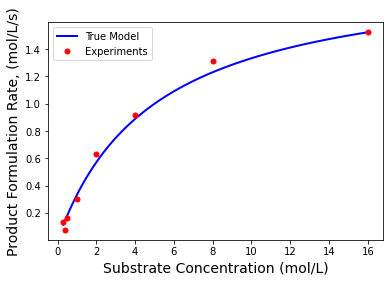

In [5]:
# Evaluate model to plot smooth curve
S = np.linspace(np.min(Sexp),np.max(Sexp),100)
r = Vmaxexact*S / (Kmexact+S)

plt.plot(S,r,'b-',linewidth=2,label="True Model")
plt.plot(Sexp,rexp,'r.',markersize=10,label="Experiments")
plt.xlabel('Substrate Concentration (mol/L)',fontsize=14)
plt.ylabel('Product Formulation Rate, (mol/L/s)',fontsize=14)
plt.legend()
plt.show()

## Step 1: Transformation

It turns out we can apply a mathematical transformation to the independent and dependent variables to rewrite the Michaelis-Menten equation as a linear regression. Specifically,

$$\underbrace{\frac{1}{r}}_{y} = \beta_1 \underbrace{\frac{1}{[\mathrm{S}]}}_{x} + \beta_0$$

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Show all of the steps to derive this model expression. Determine expressions to compute $V_{max}$ and $K_M$ from $\beta_0$ and $\beta_1$.
</div>

## Step 2: Calculate Best Fit and Plot

We will start by performing linear regression with the transformed model. We will use the `linregress` function in `scipy.stats`.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Add units to the code below.
</div>

In [6]:
y = 1/rexp
x = 1/Sexp

# note: the standard error is for the slope, not the residuals!
b1_, b0_, r_value, p_value, std_err = stats.linregress(x, y)

print("slope = ",b1_,"add units")
print("intercept =",b0_,"add units")
print("r = ",r_value)


slope =  3.0934262548165474 add units
intercept = 0.5289050063031437 add units
r =  0.8577020287799824


Next, we can transform $\beta_0$ and $\beta_1$ into $V_{max}$ and $K_M$.

In [7]:
print(" ")
Vmax_lin = 1/b0_
Km_lin = b1_ / b0_
print("Vmax = ",Vmax_lin)
print("Km = ",Km_lin)

 
Vmax =  1.8906986851753234
Km =  5.848736952668471


<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Rerun your notebook. The answers will change. Why? (Hint: How did we generate the data.) You may find $V_{max}$ and $K_M$ are negative!
</div>

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss why $V_{max}$ and $K_M$ can be negative.
</div>


Now let's plot our fitted model. We will start by generating 100 points linearly spaced from the smallest to largest values in `x`. Then we will plot the best fit model in green.

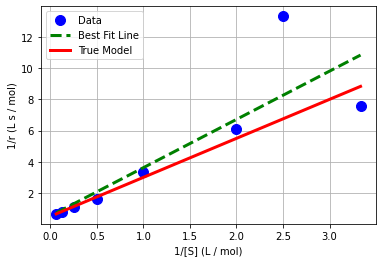

In [8]:
# generate predictions
x_pred = np.linspace(np.min(x),np.max(x),1000)
y_pred = b0_ + b1_ * x_pred

# create plot
plt.plot(x,y,'.b',markersize=20,label='Data')
plt.plot(x_pred,y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(1/S,1/r,'r-',linewidth=3,label='True Model')
plt.xlabel('1/[S] (L / mol)')
plt.ylabel('1/r (L s / mol)')
plt.grid(True)
plt.legend()
plt.show()

We can also plot in the original independent and dependent variables.

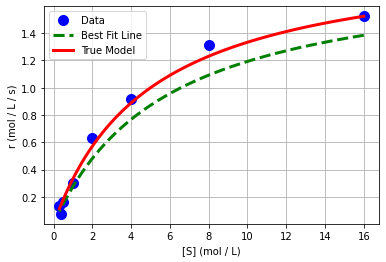

In [9]:
# create plot
plt.plot(Sexp,rexp,'.b',markersize=20,label='Data')
plt.plot(1/x_pred,1/y_pred,'--g',linewidth=3,label='Best Fit Line')
plt.plot(S,r,'r-',linewidth=3,label='True Model')
plt.xlabel('[S] (mol / L)')
plt.ylabel('r (mol / L / s)')
plt.grid(True)
plt.legend()
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss with your neighbor: why does the best fit line not appear to the fit the original data?
</div>

## Step 3. Residual Analysis

Let's proceed by analyzing the residuals. Recall, we check the residuals to verify four assumptions about the errors.

## Calculate Residuals

In [10]:
# prediction
y_hat = b0_ + b1_ * x

# residual
e = y - y_hat

## Histogram of Residuals

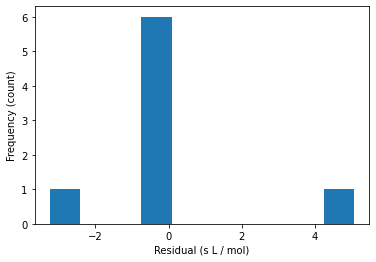

In [11]:
plt.hist(e)
plt.xlabel("Residual (s L / mol)")
plt.ylabel("Frequency (count)")
plt.show()

## Scatter Plots of Residuals

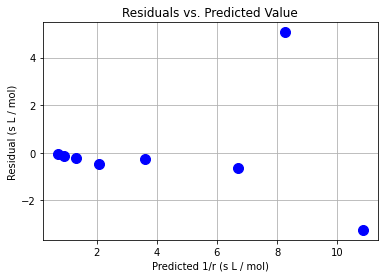

In [12]:
plt.plot(y_hat,e,"b.",markersize=20)
plt.xlabel("Predicted 1/r (s L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Predicted Value")
plt.show()

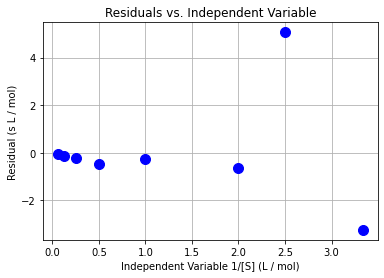

In [13]:
plt.plot(x,e,"b.",markersize=20)
plt.xlabel("Independent Variable 1/[S] (L / mol)")
plt.ylabel("Residual (s L / mol)")
plt.grid(True)
plt.title("Residuals vs. Independent Variable")
plt.show()

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the residuals pass the diagnostic tests? Discuss with your neighbor.

## Step 3. Uncertainty Analysis / Calculate Covariance Matrix

We can easily calculate the covariance matrix for $\beta$ = $[\beta_0, \beta_1]^T$:

In [14]:
# assemble feature matrix
X = np.ones((len(x),2))
X[:,1] = x

print("X =\n",X)

X =
 [[1.         3.33333333]
 [1.         2.5       ]
 [1.         2.        ]
 [1.         1.        ]
 [1.         0.5       ]
 [1.         0.25      ]
 [1.         0.125     ]
 [1.         0.0625    ]]


In [15]:
# calculate inverse of XT * X
XXinv = np.linalg.inv(X.transpose().dot(X))
print("inv(XT X) =\n",XXinv)

inv(XT X) =
 [[ 0.2636409  -0.11351409]
 [-0.11351409  0.09294117]]


In [16]:
# recall we can calculate the best fit coefficients with linear algebra
beta_hat = XXinv @ X.transpose() @ y
print("beta_hat =",beta_hat)

beta_hat = [0.52890501 3.09342625]


Recall from 12-01 and 12-02:

$$\Sigma_{\hat{\beta}} = \hat{\sigma}^2  (\mathbf{X}^T \mathbf{X})^{-1}$$

In [17]:
# calculate standard error (standard deviation) of residuals
se = math.sqrt((e @ e) / (len(x) - 2))
print("standard error =",se)

standard error = 2.483196100379524


In [18]:
# compute covariance matrix
Sigma_beta = se**2 * XXinv
print("covariance matrix:\n",Sigma_beta)

covariance matrix:
 [[ 1.6256791  -0.69995769]
 [-0.69995769  0.57309969]]


But the above covariance matrix is defined in terms of $\beta_0$ and $\beta_1$. Recall the transformation:

$$\beta_1 = \frac{K_m}{V_{max}}, \qquad \beta_0 = \frac{1}{V_{max}}$$

We can now apply the nonlinear error propagation formula.

Let $\beta$ = [$\beta_0$,$\beta_1$] and $\theta$ = [$V_{max}$, $K_m$]

$$
\Sigma_{\theta} \approx (\nabla_{\beta} \theta) ~ \Sigma_{\beta} ~ (\nabla_{\beta} \theta)^T
$$

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Derive the Jacobian matrix $\nabla_{\theta} \beta$ with pencil and paper.
</div>

In [19]:
## Calculate Jacobian matrix
###Express Thetas in terms of betas: Vmax = 1/b_0, Km = b_1/b_0
# gradient of Vmax w.r.t. beta
gradVmax = [-1/b0_**2, 0]

# gradient of Km w.r.t beta
gradKm = [-b1_ / b0_**2, 1/b0_]

# assemble Jacobian
jac = np.array([gradVmax, gradKm])

print("Jacobian =\n",jac)

Jacobian =
 [[ -3.57474152   0.        ]
 [-11.05819927   1.89069869]]


In [20]:
## Compute covariance matrix for parameters of interest
Sigma_theta = jac @ Sigma_beta @ jac.T
print("Covariance matrix =\n",Sigma_theta)

Covariance matrix =
 [[ 20.77419062  68.99427211]
 [ 68.99427211 230.11189747]]


## Final Thoughts

* Transformations allow us to fit *some nonlinear models* using the machinery of linear regression.
* In the old days, engineering would compute linear regression best fits using a slide rule or simple calculator.
* Transformations distort the residuals (errors).
* We will revisit this example to motivate weighted regression. I do not recommend linear regression for this problem.